In [37]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib

In [38]:
# 데이터 로딩
df = pd.read_csv("../data/processed/accident_data_filtered.csv", low_memory=False)
df["is_elderly_accident"] = (df["acdnt_age_1_code"] >= 65).astype(int)  # 65세 이상이면 1, 아니면 0
df = df.dropna(subset=["traffic_volume", "velocity"])

In [39]:
# 사용 변수 정의
target_col = "is_elderly_accident"  # 종속변수 : 고령자 사고 여부
feature_cols = [
    "occrrnc_time_code", "road_stle_dc", "lrg_violt_1_dc", "acdnt_hdc", #"wrngdo_vhcle_asort_dc", "acdnt_hdc", "lrg_violt_1_dc", "road_div", 
    "rdse_sttus_dc", "near_crosswalk", "near_traffic_light", "near_child_zone",#"near_elderly_zone", "near_disabled_zone",
    "lanes", "lengths", "velocity", "traffic_volume"
]
# 한글 매핑 정의
feature_name_map = {
    "occrrnc_time_code": "사고 시간대",
    # "wrngdo_vhcle_asort_dc" : "사고 차량 종류",
    "acdnt_hdc": "사고 유형",
    "lrg_violt_1_dc": "법규 위반 유형",
    "road_stle_dc": "도로 구조",
    "rdse_sttus_dc": "도로 상태",
    # "road_div": "도로 등급",
    "near_crosswalk": "횡단보도 인근",
    "near_traffic_light": "신호등 인근",
    "near_child_zone": "어린이 보호구역 인근",
    # "near_elderly_zone": "노인 보호구역 인근",
    # "near_disabled_zone": "장애인 보호구역 인근",
    "lanes": "차선 수",
    "lengths": "도로 길이",
    "velocity": "속도",
    "traffic_volume": "교통량"
}
data = df[feature_cols + [target_col]].copy()

In [40]:
# 결측치 처리
data["lanes"] = data["lanes"].fillna(0)
data["lengths"] = data["lengths"].fillna(0)
data["velocity"] = data["velocity"].fillna(0)
# data["road_div"] = data["road_div"].fillna(data["road_div"].median())
data["traffic_volume"] = pd.to_numeric(data["traffic_volume"], errors="coerce")
data["traffic_volume"] = data["traffic_volume"].fillna(data["traffic_volume"].median())

In [41]:
# 범주형 변수 인코딩
cat_cols = data.select_dtypes(include="object").columns.tolist()
encoder = OrdinalEncoder()
data[cat_cols] = encoder.fit_transform(data[cat_cols])

# 매핑 확인
for col, cats in zip(cat_cols, encoder.categories_):
    print(f"\n🔸 '{col}' 컬럼 매핑")
    for i, category in enumerate(cats):
        print(f"  {i} → {category}")       


🔸 'road_stle_dc' 컬럼 매핑
  0 → 교차로 - 교차로부근
  1 → 교차로 - 교차로안
  2 → 교차로 - 교차로횡단보도내
  3 → 기타 - 기타
  4 → 단일로 - 고가도로위
  5 → 단일로 - 교량
  6 → 단일로 - 기타
  7 → 단일로 - 지하차도(도로)내
  8 → 단일로 - 터널
  9 → 미분류 - 미분류
  10 → 주차장 - 주차장

🔸 'lrg_violt_1_dc' 컬럼 매핑
  0 → 교차로운행방법위반
  1 → 기타
  2 → 보행자보호의무위반
  3 → 불법유턴
  4 → 신호위반
  5 → 안전거리미확보
  6 → 안전운전불이행
  7 → 중앙선침범
  8 → 직진우회전진행방해
  9 → 차로위반

🔸 'acdnt_hdc' 컬럼 매핑
  0 → 차대사람
  1 → 차대차
  2 → 차량단독

🔸 'rdse_sttus_dc' 컬럼 매핑
  0 →  건조
  1 →  기타
  2 →  서리/결빙
  3 →  적설
  4 →  젖음/습기
  5 →  침수
  6 →  해빙


In [42]:
# X, y 분리
X = data.drop(columns=[target_col])
y = data[target_col]

In [43]:
# 학습/테스트 분할
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train = X
y_train = y

In [44]:
# 모델 학습
model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
# SHAP 분석
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

<Figure size 500x500 with 0 Axes>

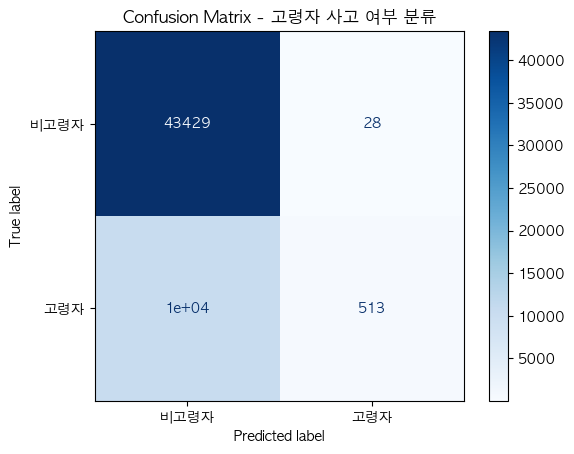

In [46]:
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

y_pred = model.predict(X)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["비고령자", "고령자"])
plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - 고령자 사고 여부 분류")
plt.grid(False)
plt.show()

In [47]:
# 평균 영향도 계산
shap_df = pd.DataFrame(shap_values, columns=X.columns)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

# Top 10 영향 변수 정리
top_features = mean_abs_shap.head(10).reset_index()
top_features.columns = ["Feature", "Mean |SHAP Value|"]
top_features

,Feature,Mean |SHAP Value|
0,occrrnc_time_code,0.206524
1,velocity,0.128345
2,traffic_volume,0.119013
3,lengths,0.101903
4,lrg_violt_1_dc,0.078106
5,road_stle_dc,0.062930
6,acdnt_hdc,0.047432
7,lanes,0.045848
8,near_crosswalk,0.035208
9,near_traffic_light,0.030024


## SHAP summary_plot
**🔴 빨강 = 해당 특성 값이 높음<br>
🔵 파랑 = 해당 특성 값이 낮음**


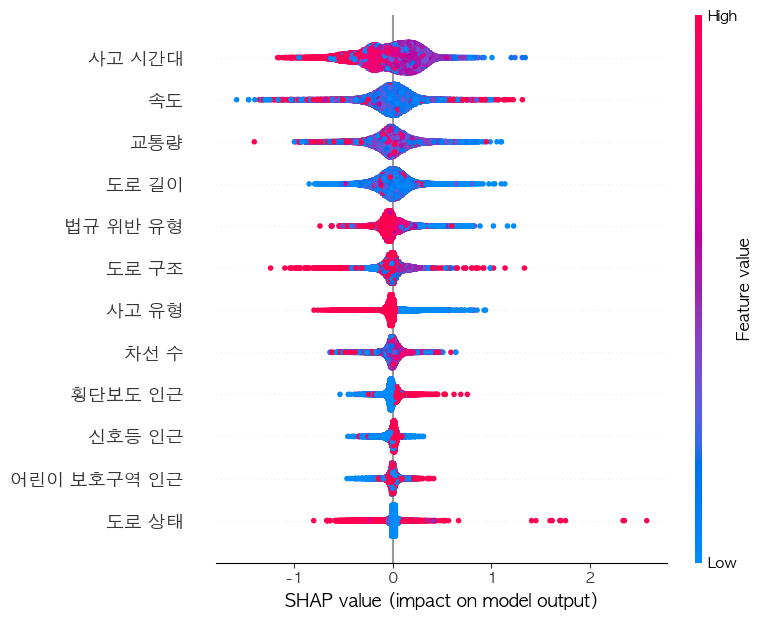

In [48]:
# 요약 시각화
X.columns = X.columns.map(lambda col: feature_name_map.get(col, col))
shap.summary_plot(shap_values, X)

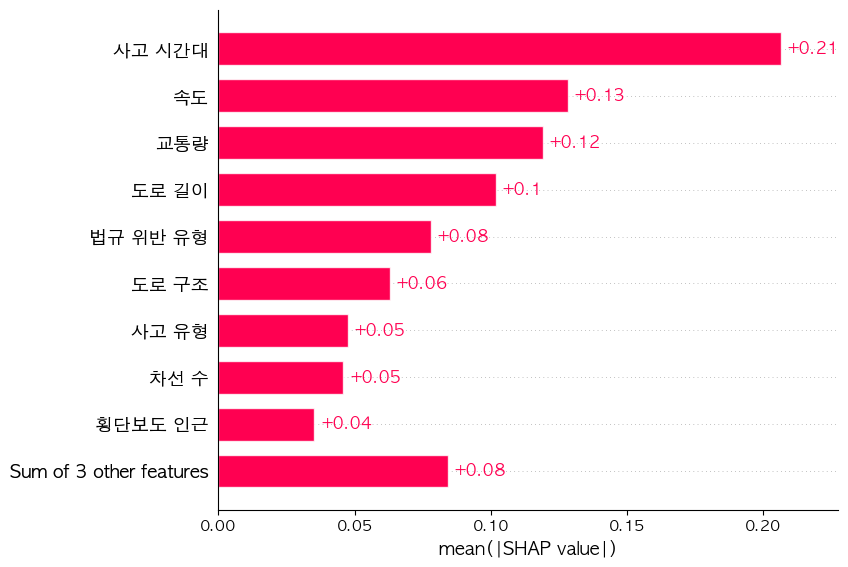

In [49]:
# SHAP 값이 다차원인 경우 (예: 이진분류 → 클래스별 SHAP)
if isinstance(shap_values, list):
    shap_vals = shap_values[1]  # 양성 클래스 기준으로
    base_val = explainer.expected_value[1]
else:
    shap_vals = shap_values
    base_val = explainer.expected_value

# 전체 데이터 요약 bar plot
shap.plots.bar(
    shap.Explanation(
        values=shap_vals,
        base_values=base_val,
        data=X,
        feature_names=X.columns
    )
)

## 사고 시간대 상관관계 분석

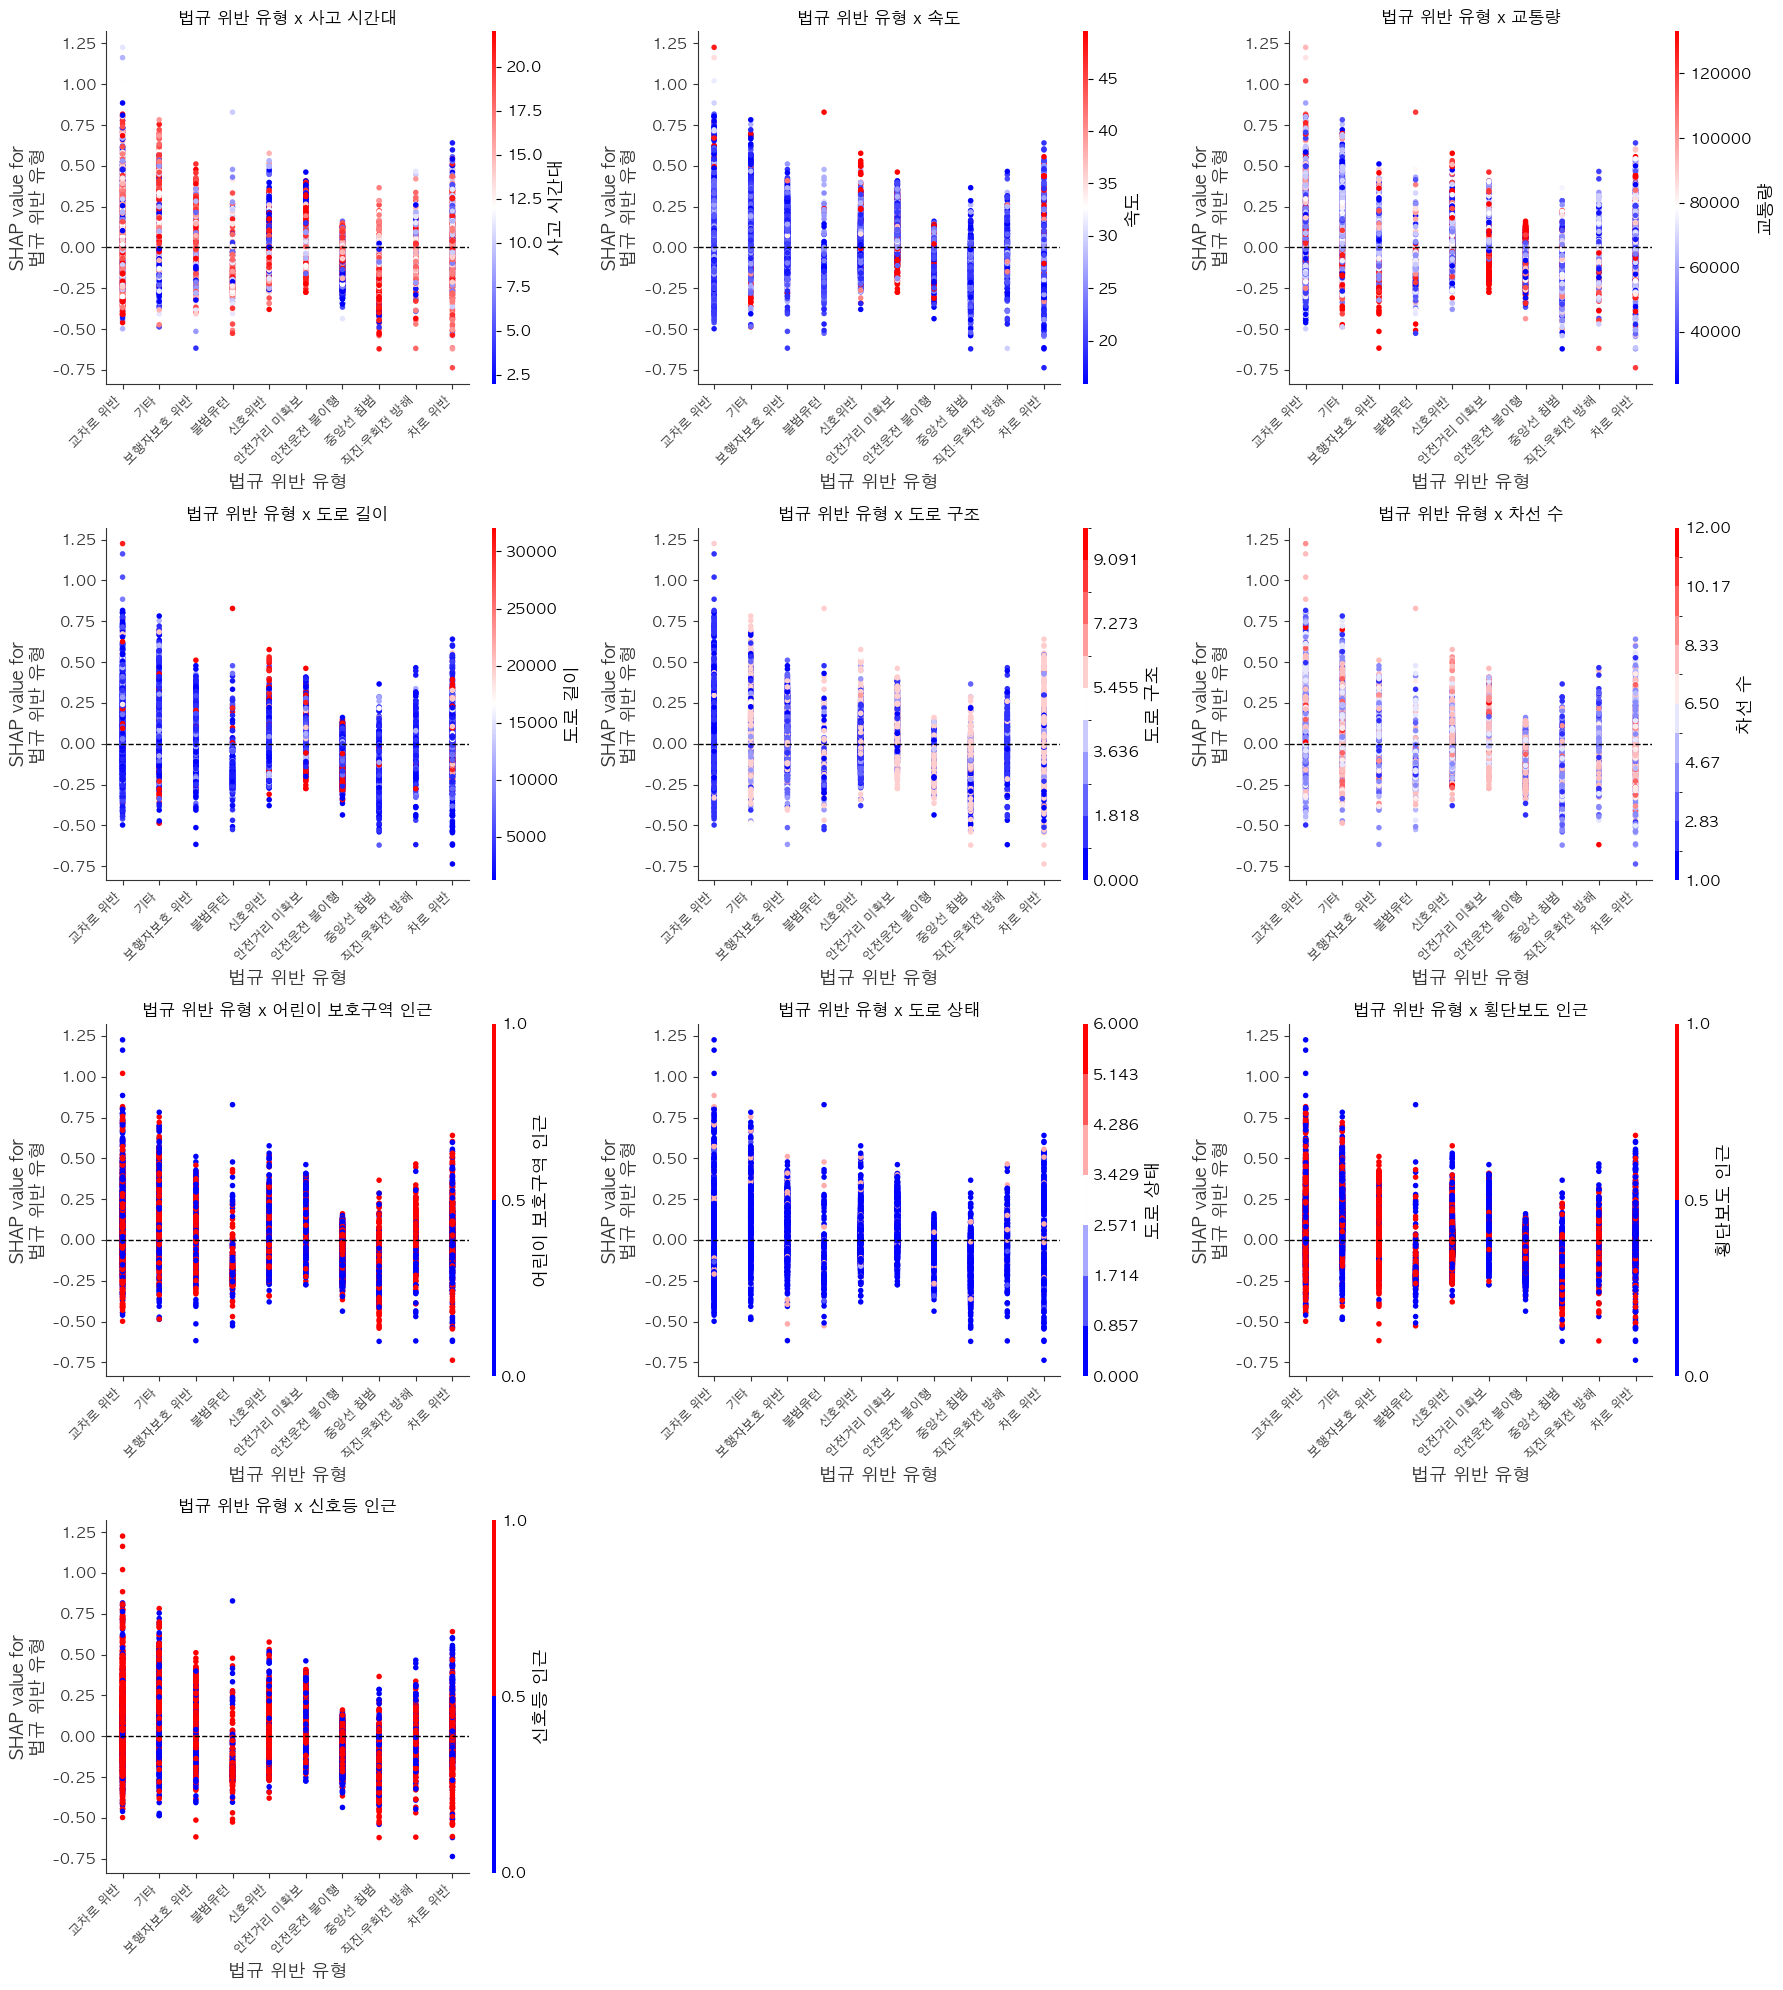

In [50]:
# 기본 설정
target_feature = "법규 위반 유형"
color_candidates = ["사고 시간대", "속도", "교통량", "도로 길이", "도로 구조", "차선 수", "어린이 보호구역 인근", 
                    "도로 상태", "횡단보도 인근", "신호등 인근"]
cols = 3
rows = math.ceil(len(color_candidates) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

violation_labels = [
    "교차로 위반",        # 0
    "기타",              # 1
    "보행자보호 위반",   # 2
    "불법유턴",          # 3
    "신호위반",          # 4
    "안전거리 미확보",   # 5
    "안전운전 불이행",   # 6
    "중앙선 침범",       # 7
    "직진·우회전 방해",  # 8
    "차로 위반"          # 9
]

# 2. ▶️ 루프 내부에 X축 레이블 수동 변경 추가 // Changed
for i, interaction_feat in enumerate(color_candidates):
    shap.dependence_plot(
        ind=target_feature,
        shap_values=shap_values,
        features=X,
        interaction_index=interaction_feat,
        ax=axes[i],
        show=False,
        cmap=plt.get_cmap("bwr")
    )
    axes[i].set_title(f"{target_feature} x {interaction_feat}", fontsize=12)
    
    axes[i].axhline(0, color="black", linestyle="--", linewidth=1)


    # X축 레이블 커스터마이징 // Changed
    axes[i].set_xticks(range(len(violation_labels)))
    axes[i].set_xticklabels(violation_labels, rotation=45, ha='right', fontsize=9)


# 남은 subplot 빈칸 제거;'?
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 법규 위반 유형 x 사고시간대
- 이른 시간대의 SHAP 값이 높음 &rarr; 이른 시간대일 수록 사고 발생 예측 기여가 높다
- `교차로 위반`, `중앙선 침범`, `안전거리 미확보` 등이 특히 높은 연관성을 보임 

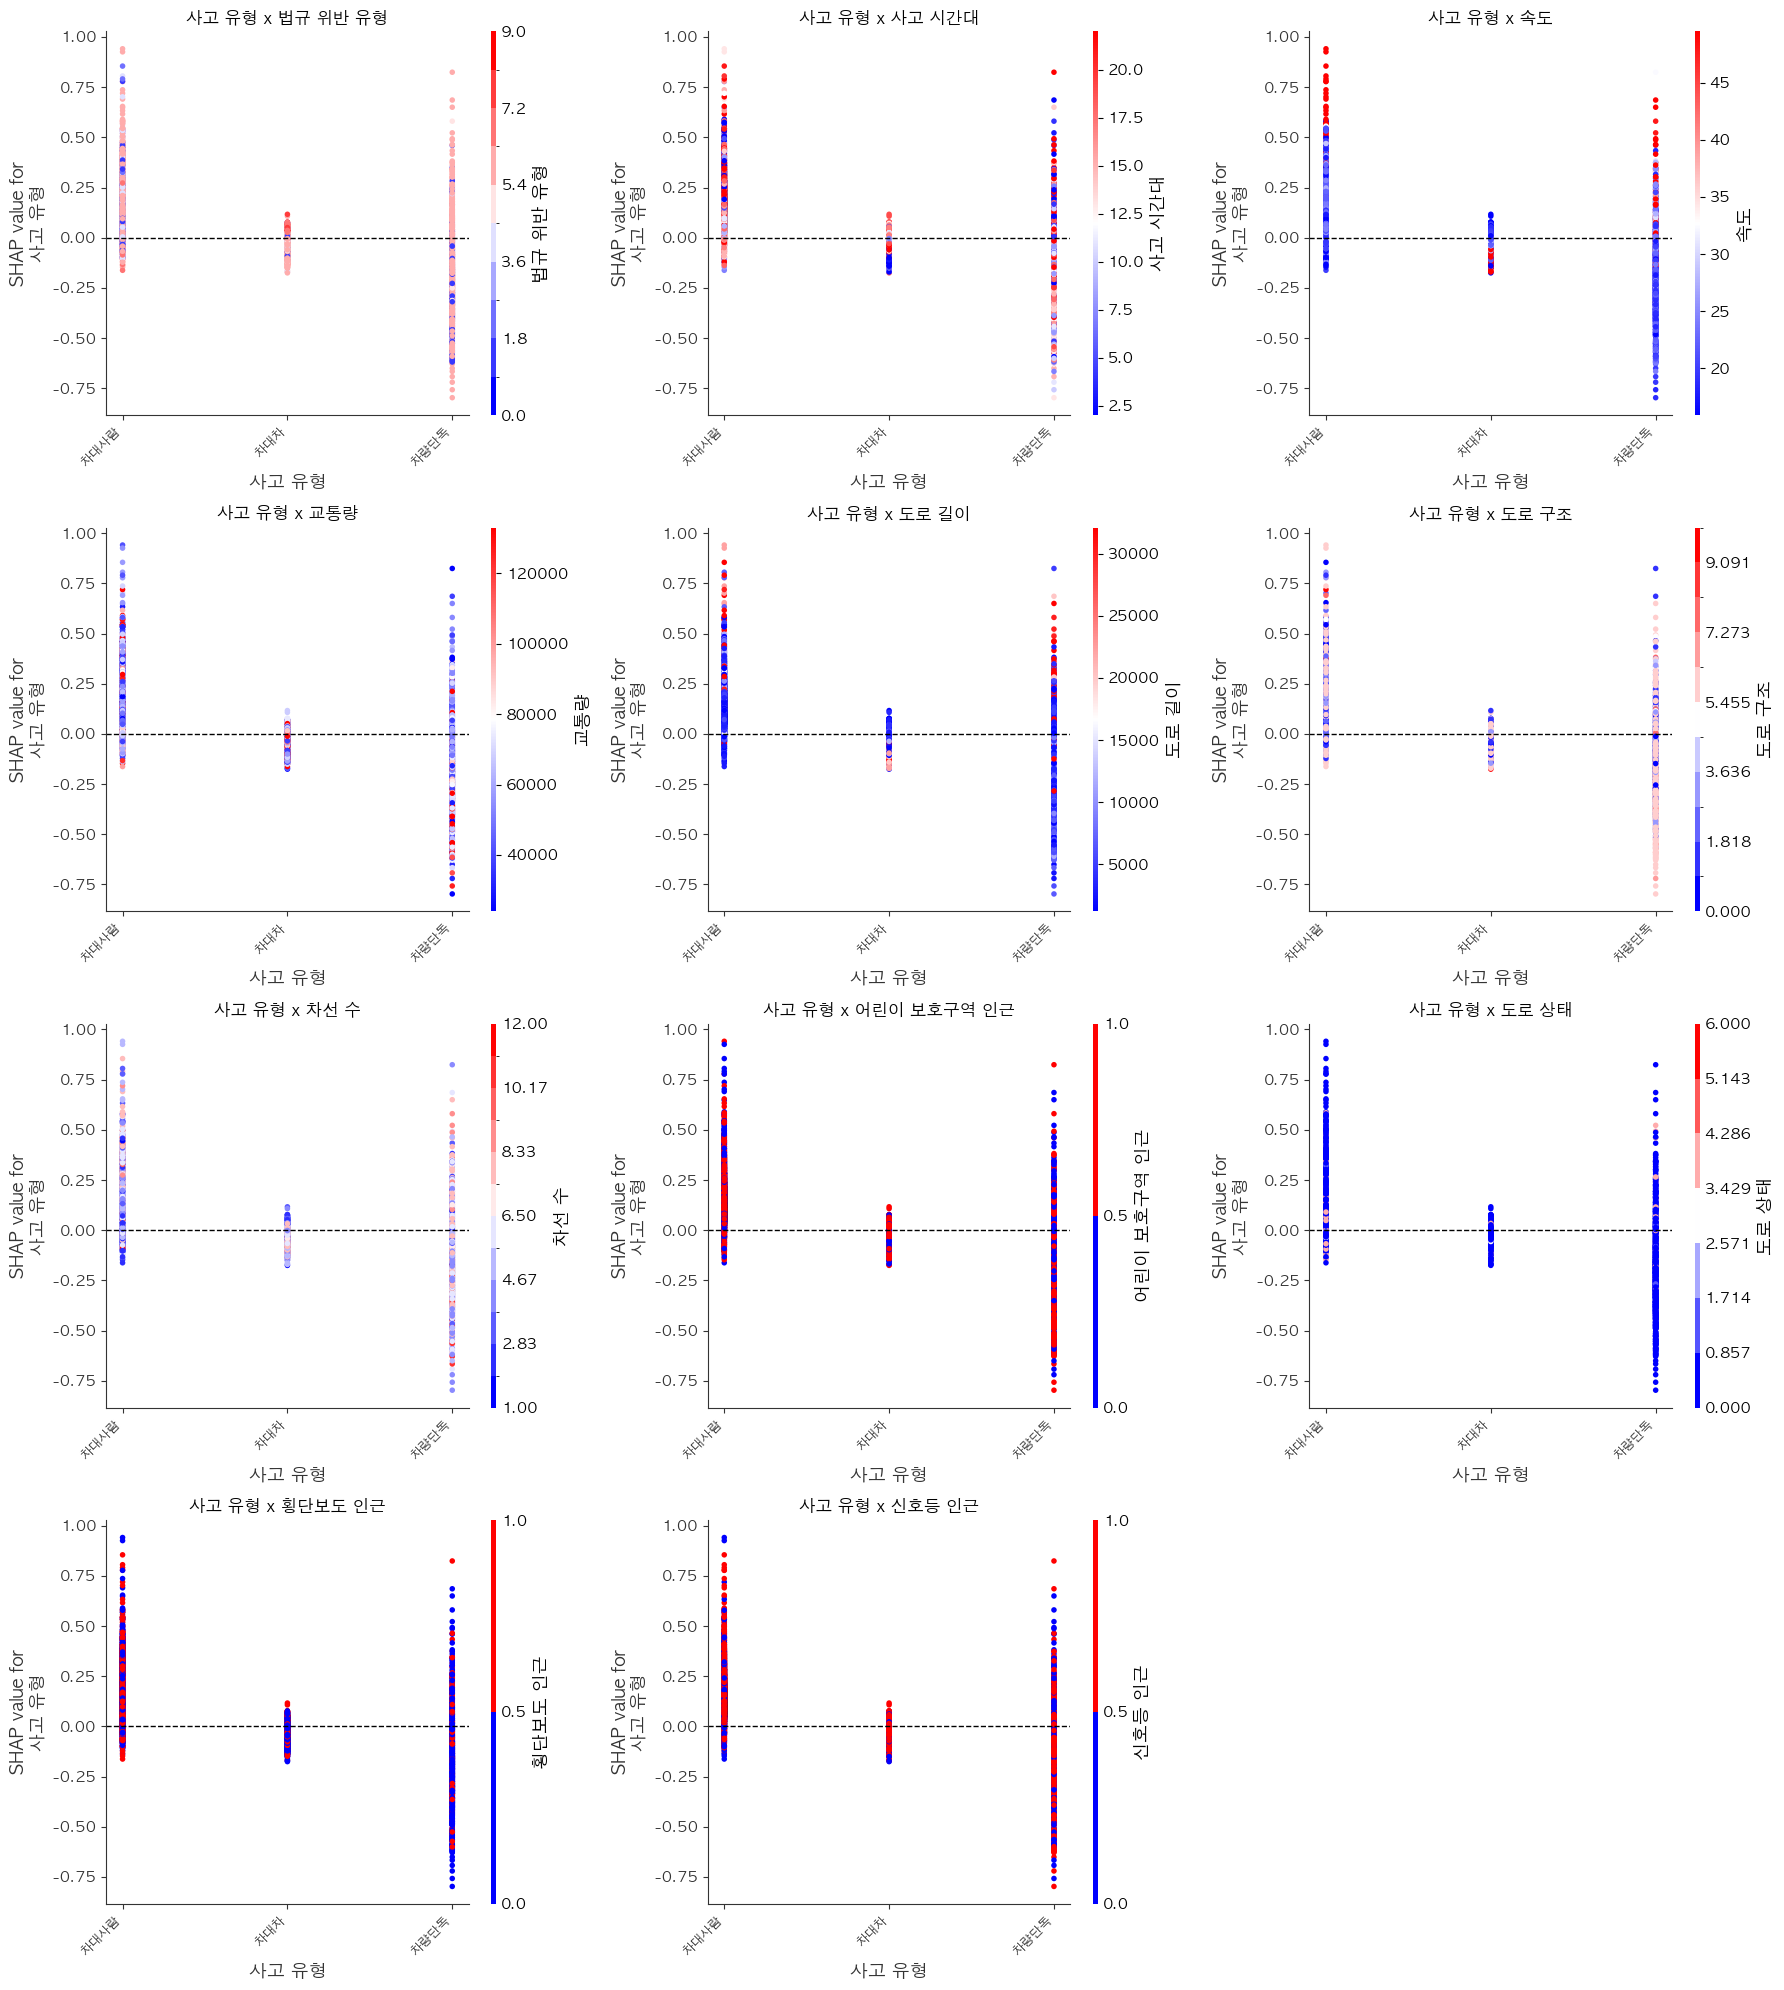

In [51]:
# 기본 설정
target_feature = "사고 유형"
color_candidates = ["법규 위반 유형", "사고 시간대", "속도", "교통량", "도로 길이", "도로 구조", "차선 수", "어린이 보호구역 인근", 
                    "도로 상태", "횡단보도 인근", "신호등 인근"]
cols = 3
rows = math.ceil(len(color_candidates) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
axes = axes.flatten()

violation_labels = [
    "차대사람",        # 0
    "차대차",              # 1
    "차량단독",   # 2
]

# 2. ▶️ 루프 내부에 X축 레이블 수동 변경 추가 // Changed
for i, interaction_feat in enumerate(color_candidates):
    shap.dependence_plot(
        ind=target_feature,
        shap_values=shap_values,
        features=X,
        interaction_index=interaction_feat,
        ax=axes[i],
        show=False,
        cmap=plt.get_cmap("bwr")
    )
    axes[i].set_title(f"{target_feature} x {interaction_feat}", fontsize=12)
    
    axes[i].axhline(0, color="black", linestyle="--", linewidth=1)


    # X축 레이블 커스터마이징 // Changed
    axes[i].set_xticks(range(len(violation_labels)))
    axes[i].set_xticklabels(violation_labels, rotation=45, ha='right', fontsize=9)


# 남은 subplot 빈칸 제거;'?
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()